In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
    
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm

import random, time

from torch.utils.tensorboard import SummaryWriter

from datasets import synthetic as load_datasets
from datasets import real as load_real_datasets
from datasets import real_only as load_only_real_datasets
from utils import plotter, visualizer

import metrics
from models import PVT, UNet, ResNet, ConvNext, ViT

import trainer as train_funct
from trainer import Trainer

/home/firp/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/firp/.local/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
writer = SummaryWriter()

In [3]:
train_funct.set_seed(42)

## Dataset

In [4]:
train_datapath = "Datasets/Training_set"
val_datapath = "Datasets/Validation_set"
test_datapath = "Datasets/Test_set"

In [5]:
train_data = load_datasets.SonarDescriptorDatasetFull(train_datapath, None)
val_data = load_datasets.SonarDescriptorDatasetFull(val_datapath, train_data)
test_data = load_datasets.SonarDescriptorDatasetFull(test_datapath, train_data)

In [6]:
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Training: 31375
Validation: 4000
Test: 4000


In [7]:
real_data = load_real_datasets.SonarDescriptorRealDataset(None, None)

In [8]:
print("Real: " + str(len(real_data.imgs)))

Real: 2182


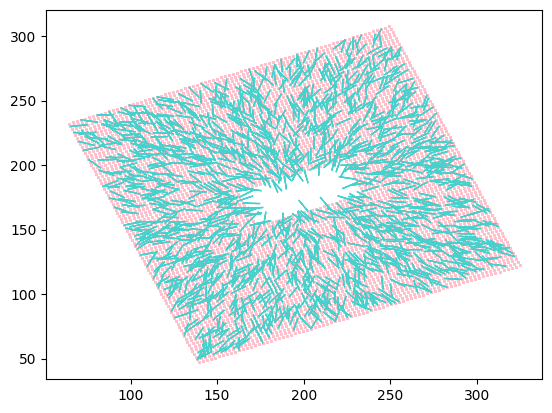

In [9]:
plotter.plot_train_data(train_data)

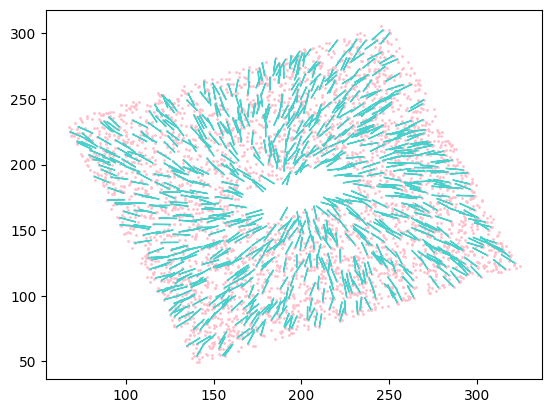

In [10]:
plotter.plot_data(val_data)

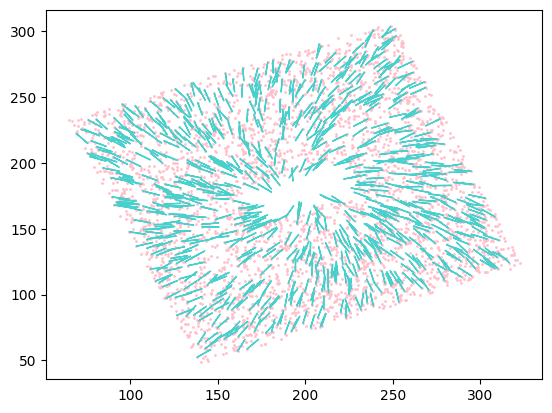

In [11]:
plotter.plot_data(test_data)

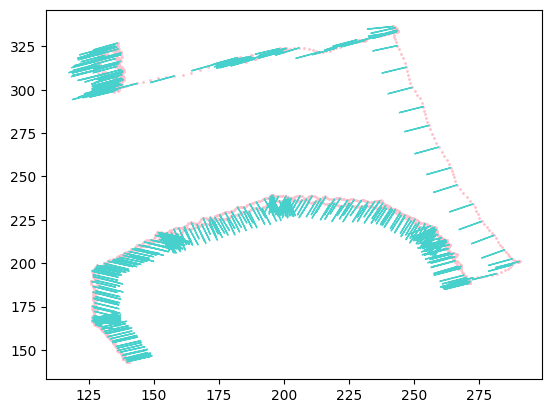

In [12]:
plotter.plot_data(real_data)

In [13]:
q_pose = real_data.poses[700]

q_x, q_y, q_Y_deg = q_pose
q_pose = np.array([q_x, q_y, (90+q_Y_deg)%360])

gt_pose_idx = train_data.gtquery(q_x, q_y, q_Y_deg)

Training before filtering: 31375


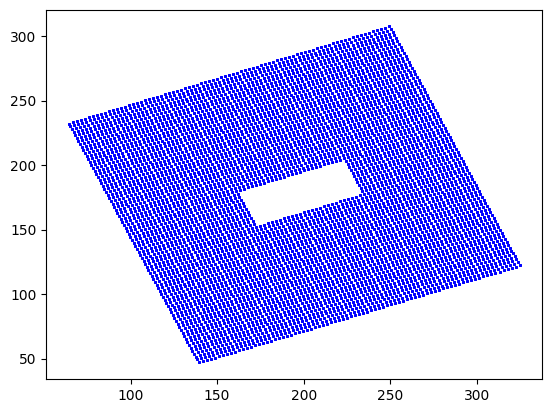

In [14]:
plotter.plot_synth_poses_train(train_data, "blue")
print("Training before filtering: " + str(len(train_data.imgs)))

Filtering poses: 100%|████████████████| 31375/31375 [00:00<00:00, 383501.64it/s]


Train after filtering: 26560


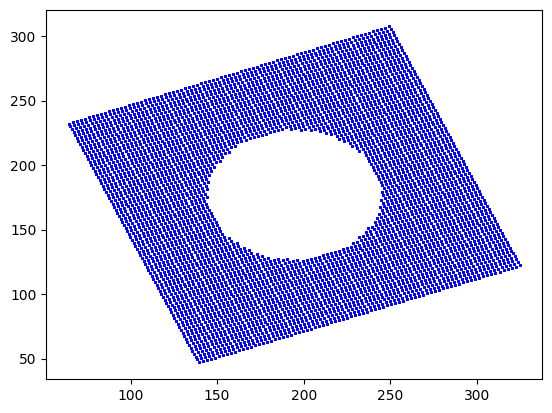

In [15]:
visualizer.filter_train_data(train_data)

plotter.plot_synth_poses_train(train_data, "blue")

print("Train after filtering: " + str(len(train_data.imgs)))

Validation before filtering: 4000


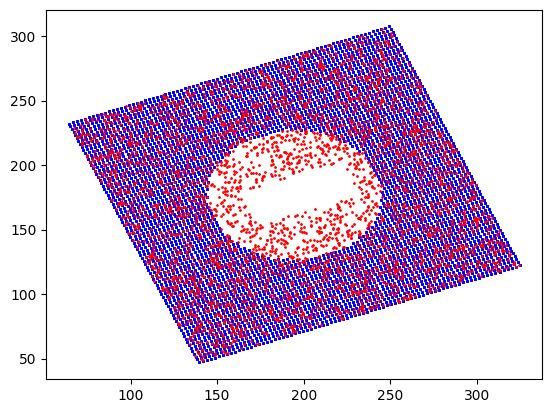

In [16]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation before filtering: " + str(len(val_data.imgs)))

Filtering poses: 100%|████████████████████| 4000/4000 [00:02<00:00, 1834.22it/s]


Validation after filtering: 3490


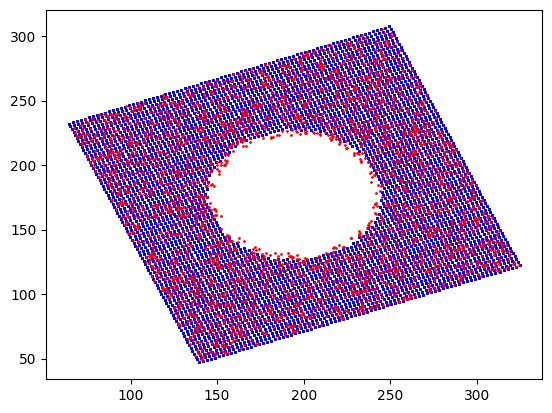

In [17]:
visualizer.filter_data(train_data, val_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation after filtering: " + str(len(val_data.imgs)))

Test before filtering: 4000


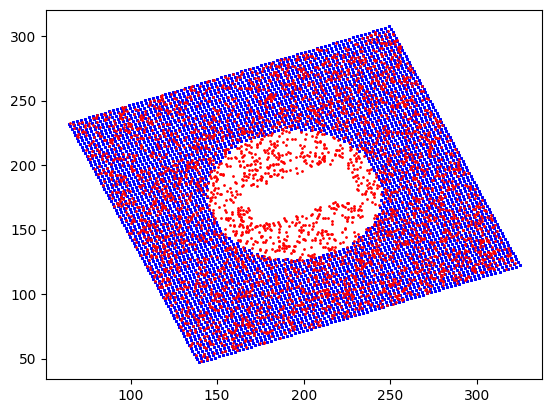

In [18]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test before filtering: " + str(len(test_data.imgs)))

Filtering poses: 100%|████████████████████| 4000/4000 [00:02<00:00, 1809.49it/s]


Test after filtering: 3502


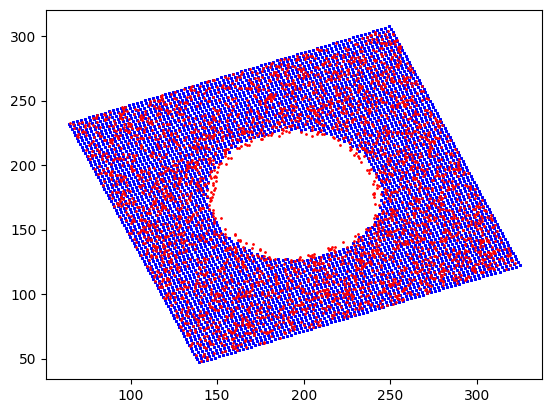

In [19]:
visualizer.filter_data(train_data, test_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test after filtering: " + str(len(test_data.imgs)))

iou: 0.9582056792165464
yaw difference tensor(4.9431) deg
localization error:  0.032426458 meters


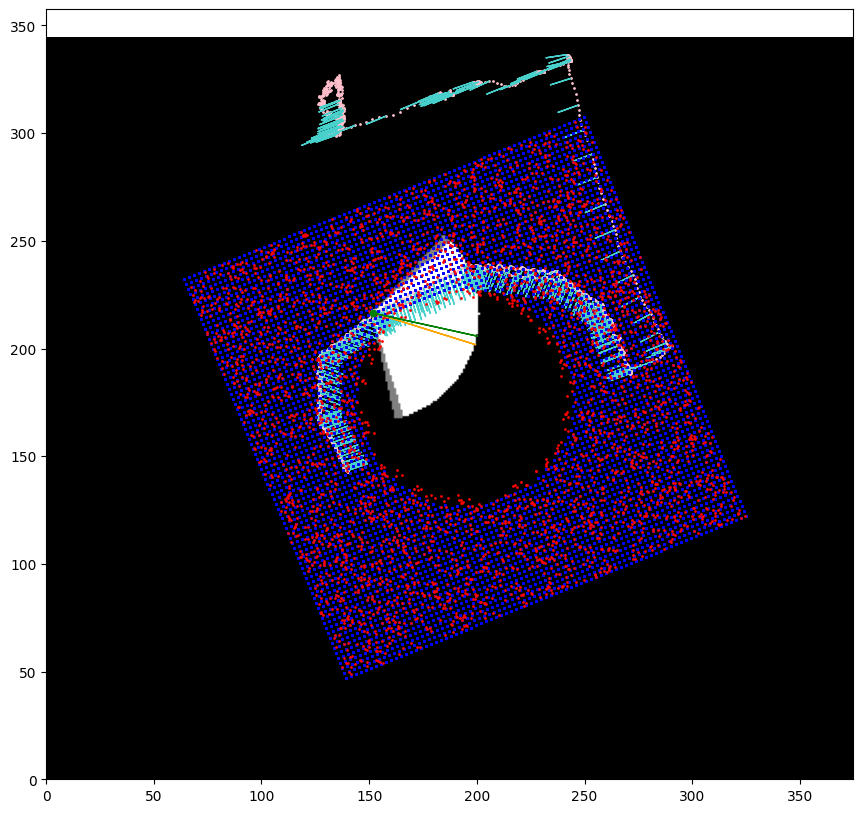

<Figure size 640x480 with 0 Axes>

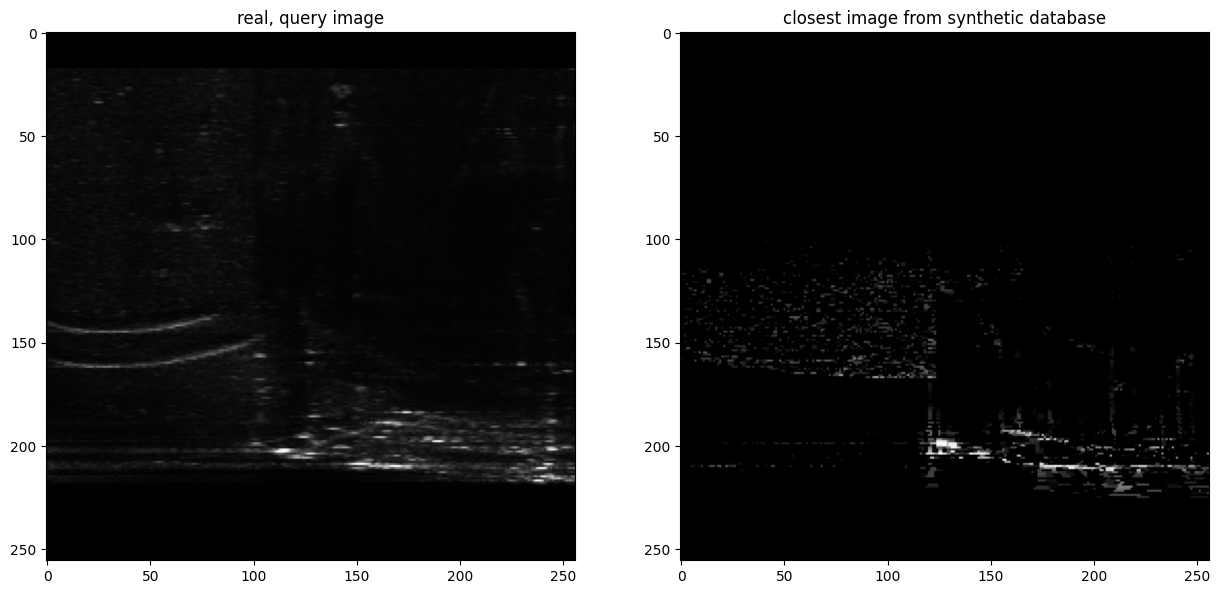

In [20]:
visualizer.localization(train_data, val_data, real_data)

In [21]:
print("Datasets before ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets before ground truth check
Training: 26560
Validation: 3490
Test: 3502


In [22]:
val_data = visualizer.check_gt(train_data, val_data)

In [23]:
test_data = visualizer.check_gt(train_data, test_data)

In [24]:
print("Datasets after ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets after ground truth check
Training: 26560
Validation: 3488
Test: 3496


In [25]:
model_name = "UNet"

In [26]:
batch = 16
train_dataloader = DataLoader(train_data, batch_size=batch, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch, shuffle=True)

## Model

### Model instantiation

In [27]:
net = UNet.Model().cuda()
net.train()

optimizer = torch.optim.AdamW(net.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=len(train_data), gamma=0.8)

drop = torch.nn.Dropout(0.3).cuda()

In [28]:
locacriterion = torch.nn.CrossEntropyLoss().cuda()
recocriterion = torch.nn.MSELoss().cuda()

In [29]:
total_params = metrics.count_parameters(net)
print("Total parameters: ", total_params)

Total parameters:  31042633


## Training Pipeline

### Train epochs

In [ ]:
trainer = Trainer(writer, train_data, train_dataloader, val_data, val_dataloader, net, optimizer, scheduler, drop, recocriterion, locacriterion)
num_epochs = 12

start_train = time.time()
best_model_path, best_val_loca_error, best_val_orie_error = trainer.train(num_epochs)
end_train = time.time()

training_time = end_train - start_train
print("Training time: ", training_time, "seconds")

epoch: 1


100%|███████████████████████████████████████| 1660/1660 [32:33<00:00,  1.18s/it]


train loss mean: 1.389827549265675
train loss reco: 0.03682977742878776
train loss loca: 0.13529977734082838


100%|█████████████████████████████████████████| 218/218 [04:12<00:00,  1.16s/it]


val loss mean: 6.002579886190713
val loss reco: 5.55436677953929
val loss loca: 0.044821316247338754
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [03:54<00:00, 113.43it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:30<00:00, 114.73it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [09:29<00:00,  6.13it/s]


average localization error: 3.4905 meters
average orientation error : 25.3508 degrees
epoch: 2


100%|███████████████████████████████████████| 1660/1660 [31:57<00:00,  1.16s/it]


train loss mean: 0.8192884361034776
train loss reco: 0.0050061707205352295
train loss loca: 0.08142822439086635


100%|█████████████████████████████████████████| 218/218 [04:03<00:00,  1.12s/it]


val loss mean: 0.1487078697958944
val loss reco: 0.021114799800679224
val loss loca: 0.012759307138258676
computing dataset descriptors


100%|█████████████████████████████████████| 26560/26560 [04:51<00:00, 91.26it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:29<00:00, 118.16it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [09:12<00:00,  6.31it/s]


average localization error: 3.7256 meters
average orientation error : 28.8203 degrees
epoch: 3


100%|███████████████████████████████████████| 1660/1660 [31:41<00:00,  1.15s/it]


train loss mean: 0.07402889163468976
train loss reco: 0.002875464920765238
train loss loca: 0.007115342660669619


100%|█████████████████████████████████████████| 218/218 [04:02<00:00,  1.11s/it]


val loss mean: 0.02192288840300651
val loss reco: 0.0019207222081737917
val loss loca: 0.0020002166296295616
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [03:32<00:00, 124.92it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:28<00:00, 124.15it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [09:01<00:00,  6.45it/s]


average localization error: 2.0841 meters
average orientation error : 17.2652 degrees
epoch: 4


100%|███████████████████████████████████████| 1660/1660 [31:36<00:00,  1.14s/it]


train loss mean: 0.030297334343531584
train loss reco: 0.001372450656827023
train loss loca: 0.002892488365746047


100%|█████████████████████████████████████████| 218/218 [04:02<00:00,  1.11s/it]


val loss mean: 0.026286124388490796
val loss reco: 0.001509919892377092
val loss loca: 0.002477620455966152
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [03:32<00:00, 125.20it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:27<00:00, 125.06it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [08:54<00:00,  6.53it/s]


average localization error: 2.9240 meters
average orientation error : 24.3667 degrees
epoch: 5


100%|███████████████████████████████████████| 1660/1660 [31:25<00:00,  1.14s/it]


train loss mean: 0.022578389286231924
train loss reco: 0.0012795024296179056
train loss loca: 0.0021298886840273794


100%|█████████████████████████████████████████| 218/218 [04:01<00:00,  1.11s/it]


val loss mean: 0.027906284436856936
val loss reco: 0.0038979250271249256
val loss loca: 0.00240083593849003
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [03:34<00:00, 123.98it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:27<00:00, 124.66it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [08:54<00:00,  6.53it/s]


average localization error: 2.5592 meters
average orientation error : 22.5093 degrees
epoch: 6


100%|███████████████████████████████████████| 1660/1660 [31:28<00:00,  1.14s/it]


train loss mean: 0.02251371044429939
train loss reco: 0.0013717097714851913
train loss loca: 0.002114200064595452


100%|█████████████████████████████████████████| 218/218 [04:02<00:00,  1.11s/it]


val loss mean: 0.014797568158887395
val loss reco: 0.0014065717434544765
val loss loca: 0.0013390996390868217
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [03:32<00:00, 124.91it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:27<00:00, 125.41it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [09:02<00:00,  6.43it/s]


average localization error: 1.6802 meters
average orientation error : 11.8916 degrees
epoch: 7


100%|███████████████████████████████████████| 1660/1660 [31:45<00:00,  1.15s/it]


train loss mean: 0.019444886613525
train loss reco: 0.0012135652997755412
train loss loca: 0.001823132132083256


100%|█████████████████████████████████████████| 218/218 [04:02<00:00,  1.11s/it]


val loss mean: 0.015350736713959673
val loss reco: 0.002133378940057693
val loss loca: 0.001321735781331898
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [03:32<00:00, 124.78it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:28<00:00, 124.42it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [09:07<00:00,  6.37it/s]


average localization error: 1.6702 meters
average orientation error : 14.8730 degrees
epoch: 8


100%|███████████████████████████████████████| 1660/1660 [31:56<00:00,  1.15s/it]


train loss mean: 0.019589102757724384
train loss reco: 0.0013110780895264056
train loss loca: 0.0018278024677630424


100%|█████████████████████████████████████████| 218/218 [04:17<00:00,  1.18s/it]


val loss mean: 2.2708600843472873e+20
val loss reco: 2.2708600843472873e+20
val loss loca: 0.026125864757394736
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [03:39<00:00, 121.12it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:27<00:00, 125.89it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [09:06<00:00,  6.39it/s]


average localization error: 2.6933 meters
average orientation error : 23.1678 degrees
epoch: 9


100%|███████████████████████████████████████| 1660/1660 [31:45<00:00,  1.15s/it]


train loss mean: 0.03770624521884125
train loss reco: 0.009943917119687602
train loss loca: 0.002776232814410679


100%|█████████████████████████████████████████| 218/218 [04:03<00:00,  1.12s/it]


val loss mean: 0.019227316823078815
val loss reco: 0.002571250349411382
val loss loca: 0.0016656066462586616
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [03:49<00:00, 115.86it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:29<00:00, 119.07it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [09:00<00:00,  6.45it/s]


average localization error: 3.0811 meters
average orientation error : 25.0333 degrees
epoch: 10


100%|███████████████████████████████████████| 1660/1660 [31:27<00:00,  1.14s/it]


train loss mean: 0.023380609586027012
train loss reco: 0.00195636729820609
train loss loca: 0.0021424242280246916


100%|█████████████████████████████████████████| 218/218 [04:01<00:00,  1.11s/it]


val loss mean: 0.013122988638357012
val loss reco: 0.001408783442857718
val loss loca: 0.0011714205206980622
computing dataset descriptors


100%|████████████████████████████████████| 26560/26560 [03:33<00:00, 124.69it/s]


descriptors computed!
computing dataset descriptors


100%|██████████████████████████████████████| 3488/3488 [00:28<00:00, 124.40it/s]


descriptors computed!
computing metrics


100%|███████████████████████████████████████| 3488/3488 [08:56<00:00,  6.50it/s]


average localization error: 1.7643 meters
average orientation error : 14.0747 degrees
epoch: 11


  4%|█▊                                       | 71/1660 [01:19<29:37,  1.12s/it]

In [ ]:
inference_time_per_image = metrics.inference_time(net, train_dataloader)
print("Inference time per image: ", inference_time_per_image, "seconds")

In [ ]:
input_tensor = next(iter(val_dataloader))[0].cuda()
inference_memory_per_batch = metrics.inference_memory(net, input_tensor)
print("Inference memory for batch: ", inference_memory_per_batch, "MB")

In [ ]:
metrics.get_descriptors(train_data, val_data, net)

## Visualize Training results on Test data

### Load the checkpoint model

In [ ]:
checkpoint_path = best_model_path
print("Best model path: ", best_model_path)
print("Validation loca error with best model: ", best_val_loca_error)
print("Validation orie error with best model: ", best_val_orie_error)
#checkpoint_path = "correct_model_3/epoch_10.pth"
net = UNet.Model()
train_funct.load_state(net, checkpoint_path)

net = net.cuda()
net.eval();

### Compute the final descriptors of the training data

### Query the database

In [ ]:
train_data.apply_random_rot = False
train_data.computeDescriptors(net)

### Visualize query results: sonar images

In [ ]:
import pickle

with open("train_data.pickle", "wb") as handle:
    pickle.dump(train_data, handle)

In [ ]:
visualizer.analyze_feature_robustness(train_data, net)

In [ ]:
query_idx = random.randint(0, len(test_data))

loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [ ]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(test_data))):
    loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.array(orie_errors).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

ale_t = avg_loca_error
aoe_t = avg_orie_error

In [ ]:
loca_errors = np.array(loca_errors)
orie_errors = np.array(orie_errors)

In [ ]:
loca_errors.argmax()

In [ ]:
le = loca_errors[loca_errors<10]
oe = orie_errors[orie_errors<10]
print(le.mean())
print(oe.mean())

## Process real images

In [ ]:
query_idx = random.randint(0, 600)
train_data.apply_random_rot = True
train_data.training = True
print("query_idx:", query_idx)
visualizer.process_real(query_idx, net, train_data, real_data)

## Process ONLY real images

In [ ]:
real_data_train = load_only_real_datasets.SonarDescriptorOnlyRealDataset()
real_data_valid = load_only_real_datasets.SonarDescriptorOnlyRealDataset(real_data_train)

In [ ]:
real_data_train.computeDescriptors(net)

In [ ]:
visualizer.visualize_real(train_data, real_data)

In [ ]:
query_idx = random.randint(700, len(real_data_valid))
loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [ ]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(real_data_valid))):
    loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.abs(np.array(orie_errors)).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

ale_r = avg_loca_error
aoe_r = avg_orie_error

In [ ]:
avg_orie_error.min()

## Results

In [ ]:
file_path = "results.csv"
metrics.save_results(model_name, total_params, training_time, inference_time_per_image, inference_memory_per_batch, ale_t, aoe_t, ale_r, aoe_r, file_path)

print(f"Model name: {model_name}")
print(f"Total parameters: {total_params}")
print(f"Training time: {training_time:6.4f} seconds")
print(f"Inference time per image: {inference_time_per_image:6.4f} seconds")
print(f"Inference memory per batch: {inference_memory_per_batch:6.4f} MB")
print(f"Average localization error in Test: {ale_t:6.4f} meters")
print(f"Average orientation error in Test: {aoe_t:6.4f} degrees")
print(f"Average localization error in Real: {ale_r:6.4f} meters")
print(f"Average orientation error in Real: {aoe_r:6.4f} degrees")